In [1]:
import json
import numpy as np
import datetime
from collections import Counter
import itertools
import matplotlib.pyplot as plt
from sklearn import svm
import math
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MultiLabelBinarizer
from numpy import linalg as la
from sklearn.neural_network import MLPClassifier



In [2]:
def get_tip(active_records):
    #get_tip and get_review are used to get the estimated lifespan
    file = open(new_tip, 'r')
    for i in file.readlines():
        data = json.loads(i)
        id=data["business_id"]
        text=data["text"]
        date=data["date"]
        if active_records.__contains__(id):
            active_records[id].append(date)
        else:
            active_records[id]=[date]
        #likes=data["likes"]#not informative
        #print(date,id)
        #print(text)
    return(active_records)

def get_review(active_records):
    #get_tip and get_review are used to get the estimated lifespan
    file = open(new_review, 'r')
    for i in file.readlines():
        data = json.loads(i)
        id = data["business_id"]
        #text = data["text"]
        stars=data["stars"]
        date = data["date"]
        useful=data["useful"]
        funny=data["funny"]
        cool=data["cool"]
        #print(stars,useful,funny,cool)
        if active_records.__contains__(id):
            active_records[id].append(date)
        else:
            active_records[id] = [date]
    return(active_records)

def active_density_estimation(record_data):
    #used for a while, but later give up
    record=[]
    for i in record_data:
        record_year= datetime.datetime.strptime(i, '%Y-%m-%d').year
        record.append(record_year)
    record=list(dict(Counter(record)).values())
    print(record)
    if len(record)>=2:
        this_year=record[len(record)-1]*1.5
        last_year=record[len(record)-2]
        active_index=math.sqrt(this_year/12)
        lifespan_rate=active_index*math.sqrt(this_year/last_year)
    else:
        lifespan_rate=2
    return lifespan_rate

def get_restaurants():
    #get some static features
    file = open(some_restaurants, 'r')
    #categories_kind=[]
    variables={}
    categories={}
    for i in file.readlines():
        data = json.loads(i)
        id = data["business_id"]
        star=data["stars"]#continuous independent variable
        review_count=data["review_count"]#continuous independeent variable
        is_open=data["is_open"]#discrete dependent variable
        try:
            if data["attributes"]['RestaurantsGoodForGroups']==True:
                forgroups=1
            else:
                forgroups=-1#categorical independent variable
        except:
            forgroups=0
        try:
            PriceRange=int(data["attributes"]["RestaurantsPriceRange2"])#continuous independent variable
        except:
            PriceRange=0
        category=data["categories"]#categorical indenpendent variable
        #print(categories)
        variables[id]=[is_open,star,review_count,PriceRange,forgroups]
        #variables[id]=[is_open,star,review_count,PriceRange]
        categories[id]=[]
        for x in category.split(','):
            if x!=" Restaurants":
                categories[id].append(str(x))
        #categories_kind.append(categories)
    #categories_kind=list(set(categories_kind))
    #np.save("restaurant_ids.npy", ids)
    #print(len(categories_kind))
    return variables,categories


In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    """
    For visualizing the confusion matrix
    
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh=0.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [5]:
#these codes are used to get some basic features

some_restaurants = 'some_restaurants.json'
new_tip = 'some_tips.json'
new_review = 'some_reviews.json'
lifespan = []
active_records = {}
contents = np.load("restaurant_ids.npy")
restaurant_ids = contents.tolist()
active_records = get_review(active_records)
active_records = get_tip(active_records)

begin_year = []
# test_id=[]
# training_id=[]
for i in active_records:
    active_records[i] = sorted(active_records[i])
    # lifespan_rate=active_density_estimation(active_records[i])
    first = active_records[i][0]
    latest = active_records[i][len(active_records[i]) - 1]
    first_time = datetime.datetime.strptime(first, '%Y-%m-%d')
    latest_time = datetime.datetime.strptime(latest, '%Y-%m-%d')
    last = latest_time.year - first_time.year + 2
    lifespan.append(last)
    # if latest_time.year<2018:
    #    lifespan.append(last)# the training dataset, 845 data, 627 negative
    # training_id.append(i)# the training dataset
    # else:
    #    lifespan.append((last)*lifespan_rate)
    # test_id.append(i)#the test dataset, 1460 data, 57 negative
    begin_year.append(first_time.year)

variables, categories = get_restaurants()


In [6]:
#'categories' data are all categorical, so one-hot representation is needed
cats = list(categories.values())
mlb = MultiLabelBinarizer()
new_cats = mlb.fit_transform(cats)
new_cats = np.matrix(new_cats)

In [7]:
#use SVD to do the dimension reduction
U, sigma, VT = la.svd(new_cats)
Usvd = U[:, 0:100]
Usvdlist = np.array(Usvd.tolist())

In [8]:
#shuffle and create the dataset 
vari = np.array(list(variables.values()))
varia = vari[:, 1:]
data_y = vari[:, 0]
time = np.array([begin_year, lifespan])
time = np.transpose(time)
data_x = np.hstack((varia, time, Usvdlist))
#data_x = np.hstack((varia, time))
permutation = np.random.permutation(len(data_y))
data_y=data_y[permutation]
#lifespan = np.array(lifespan)
#begin_year = np.array(begin_year)
data_x=data_x[permutation, :]

In [9]:
#create the training (2000 data) and test dataset (305 data)
training_x = data_x[0:2000, :]
training_y = data_y[0:2000]
test_x = data_x[2000:, :]
test_y = data_y[2000:]

In [10]:
#run the model
print('Running Model')
#clf = MLPClassifier(activation='relu',alpha=1e-5,hidden_layer_sizes = (41,39), random_state = 1)#(40, 39)
svclassifier = svm.SVC(kernel='rbf',probability=True)#use SVM
svclassifier.fit(training_x, training_y)
#y_live = svclassifier.predict(test_x)
y_live_proba = svclassifier.predict_proba(test_x)#it's the probability
y_live = []
for i in y_live_proba:
    if i[1] > 0.7:#set new threshold, not as 0.5
        y_live.append(1)
    else:
        y_live.append(0)

Running Model


[[ 39  62]
 [ 34 170]]
Accuracy is 0.6852459016393443
F1 Score is 0.7798165137614679
Recall is 0.8333333333333334
Precision 0.7327586206896551


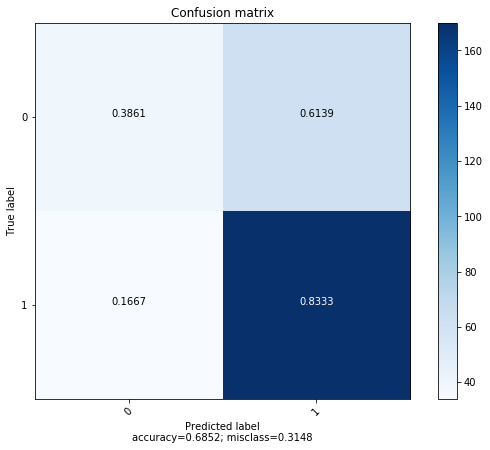

In [11]:
#get the result
cm=confusion_matrix(test_y, y_live)
print(cm)
print('Accuracy is',accuracy_score(test_y, y_live))
print('F1 Score is',f1_score(test_y, y_live))
print('Recall is',recall_score(test_y, y_live))
print('Precision',precision_score(test_y, y_live))
plot_confusion_matrix(cm,[0,1])